Load Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

Step 1: Load and Explore Data

In [2]:
data1 = pd.read_csv('data1.csv')
data2 = pd.read_csv('data2.csv')

print(data1.head())
print(data1.describe())
print(data1['sentiment'].unique())
print(data1.info())
print(f"Missing Values:\n{data1.isnull().sum()}\n")
print(f"Duplicated Rows: {data1.duplicated().sum()}")
print("\n")
print(data2.head())
print(data2.describe())
print(data2['Sentiment'].unique())
print(data2.info())
print(f"Missing Values:\n{data2.isnull().sum()}\n")
print(f"Duplicated Rows: {data2.duplicated().sum()}")

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0    

Step 2: Dataset Class for Transformers

In [3]:
# Add label mapping with normalized labels
label_mapping = {
    'positive': 0,
    'negative': 1,
    'neutral': 2
}

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        # Preprocess labels to handle spaces and case variations
        self.labels = [label_mapping[label.strip()] if label.strip() in label_mapping 
                      else label_mapping[label] for label in labels]  # Convert string labels to integers
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

Step 3: Preprocessing for Transformers

In [4]:
# Load tokenizer for pre-trained transformer model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_data(df, text_column, label_column):
    texts = df[text_column].fillna("").tolist()
    labels = df[label_column].tolist()
    # Print unique labels to see what we're dealing with
    print(f"Unique labels in {label_column}:", set(labels))
    return texts, labels

# Print unique labels before processing
print("Dataset 1 labels:")
texts1, labels1 = preprocess_data(data1, "selected_text", "sentiment")
print("\nDataset 2 labels:")
texts2, labels2 = preprocess_data(data2, "Text", "Sentiment")

# Normalize labels function
def normalize_label(label):
    # Convert to lowercase and strip whitespace
    normalized = label.lower().strip()
    # Map emotions to sentiment categories
    positive_emotions = {
        'happy', 'joy', 'excited', 'enthusiasm', 'euphoria', 'proud', 'pride', 'gratitude',
        'hope', 'optimism', 'satisfaction', 'confidence', 'admiration', 'love', 'happiness',
        'positive', 'radiance', 'dazzle', 'elation', 'triumph', 'blessed', 'success',
        'accomplishment', 'celebration', 'playful', 'inspiration', 'motivated'
    }
    negative_emotions = {
        'sad', 'angry', 'fear', 'disgust', 'grief', 'regret', 'shame', 'guilt',
        'disappointment', 'frustration', 'anxiety', 'despair', 'negative', 'heartbreak',
        'sorrow', 'depression', 'melancholy', 'hatred', 'jealousy', 'envy', 'bitterness',
        'loneliness', 'devastated', 'suffering', 'pain', 'darkness', 'desolation'
    }
    neutral_emotions = {
        'neutral', 'calm', 'indifferent', 'ambivalent', 'contemplative', 'pensive',
        'reflection', 'acceptance', 'numbness', 'confusion', 'surprise', 'wonder',
        'curiosity', 'anticipation'
    }
    # Clean the normalized label further by removing any remaining spaces
    normalized = ''.join(normalized.split())
    # Map to sentiment categories
    if any(emotion in normalized for emotion in positive_emotions):
        return 'positive'
    elif any(emotion in normalized for emotion in negative_emotions):
        return 'negative'
    else:
        return 'neutral'

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        # Normalize and convert labels
        normalized_labels = [normalize_label(label) for label in labels]
        self.labels = [label_mapping[label] for label in normalized_labels]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

# Split datasets
texts1_train, texts1_test, labels1_train, labels1_test = train_test_split(texts1, labels1, test_size=0.2, random_state=42)
texts2_train, texts2_test, labels2_train, labels2_test = train_test_split(texts2, labels2, test_size=0.2, random_state=42)

# Create PyTorch Datasets
max_length = 128
train_dataset1 = TextDataset(texts1_train, labels1_train, tokenizer, max_length)
test_dataset1 = TextDataset(texts1_test, labels1_test, tokenizer, max_length)
train_dataset2 = TextDataset(texts2_train, labels2_train, tokenizer, max_length)
test_dataset2 = TextDataset(texts2_test, labels2_test, tokenizer, max_length)

Dataset 1 labels:
Unique labels in sentiment: {'neutral', 'positive', 'negative'}

Dataset 2 labels:
Unique labels in Sentiment: {' Inspiration ', ' Excitement   ', ' Sorrow ', ' Miscalculation ', ' Curiosity   ', ' Empowerment   ', ' Betrayal ', ' Fearful ', ' Joy in Baking ', ' Ecstasy ', ' Anxiety         ', ' Exploration ', ' Reverence     ', ' Excitement ', ' Inspiration  ', ' Mesmerizing ', ' Mischievous ', ' Isolation ', ' Reflection ', ' Embarrassed ', ' Enthusiasm    ', ' Awe ', ' Darkness     ', ' Bad ', ' Melancholy      ', ' Bittersweet ', ' Apprehensive ', ' Wonder     ', ' Wonderment    ', ' Negative  ', ' Jealousy        ', ' Hope ', ' Serenity   ', ' Frustration     ', ' Radiance    ', ' Nostalgia      ', ' Numbness ', ' Optimism      ', ' Loneliness      ', ' Kind         ', ' Tenderness    ', ' Enthusiasm ', ' Happiness    ', ' Anxiety   ', ' Grandeur ', ' Euphoria      ', ' Suspense ', ' Pensive ', ' Grief      ', ' Desperation ', ' Heartbreak ', ' Colorful ', ' Comp

Step 4: Define Transformer Training Pipeline

In [5]:
def evaluate_model(model, dataset, label_list):
    trainer = Trainer(model=model, tokenizer=tokenizer)
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = dataset.labels
    print(classification_report(labels, preds, target_names=label_list))
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.show()

In [6]:
def train_sentiment_model_with_batches(data1, batch_size, num_iterations, tokenizer):
    """
    Train sentiment model multiple times on different random batches of data
    """
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
    
    for iteration in range(num_iterations):
        print(f"\nTraining iteration {iteration + 1}/{num_iterations}")
        
        # Sample a different batch each time
        batch_data = data1.sample(n=batch_size, random_state=iteration)
        
        # Split into train/test
        train_data, test_data = train_test_split(
            batch_data, 
            test_size=0.2, 
            random_state=iteration
        )
        
        # Create datasets
        train_dataset = TextDataset(
            texts=train_data['selected_text'].tolist(),
            labels=train_data['sentiment'].tolist(),
            tokenizer=tokenizer,
            max_length=128
        )
        
        test_dataset = TextDataset(
            texts=test_data['selected_text'].tolist(),
            labels=test_data['sentiment'].tolist(),
            tokenizer=tokenizer,
            max_length=128
        )
        
        # Training arguments
        training_args = TrainingArguments(
            output_dir=f"../../../ml_models/sentiment_model/iteration_{iteration}",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=3,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            load_best_model_at_end=True,
        )
        
        # Train
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=tokenizer,
        )
        
        trainer.train()
        
        # Evaluate after each iteration
        print(f"\nEvaluating iteration {iteration + 1}:")
        evaluate_model(model, test_dataset, ["Negative", "Neutral", "Positive"])
    
    return model

In [7]:
def train_transformer_model(train_dataset, test_dataset, num_labels, output_dir):
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
    iterations = 3

    # Define training arguments
    for x in range(iterations):
      print(f"\nTraining iteration {x + 1}/{iterations}")

      training_args = TrainingArguments(
          output_dir= f"{output_dir}/iteration_{x}",
          evaluation_strategy="epoch",
          save_strategy="epoch",
          learning_rate=2e-5,
          per_device_train_batch_size=16,
          per_device_eval_batch_size=16,
          num_train_epochs=3,
          weight_decay=0.01,
          logging_dir='./logs',
          logging_steps=10,
          load_best_model_at_end=True,
      )

      # Define Trainer
      trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=test_dataset,
          tokenizer=tokenizer,
      )

      # Train the model
      trainer.train()

      # Evaluate after each iteration
      print(f"\nEvaluating iteration {x + 1}:")
      evaluate_model(model, test_dataset2, ["Low", "Medium", "High"])

    return model

Training Sentiment Model with multiple iterations...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3620463509.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training iteration 1/7


2024/11/26 23:04:20 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 1.0986, 'grad_norm': 1.4449398517608643, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 1.0428, 'grad_norm': 2.855663537979126, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.976, 'grad_norm': 2.234049081802368, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.8398449420928955, 'eval_runtime': 11.9409, 'eval_samples_per_second': 12.311, 'eval_steps_per_second': 0.837, 'epoch': 1.0}
{'loss': 0.833, 'grad_norm': 2.8458163738250732, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.792, 'grad_norm': 2.7884373664855957, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.6816, 'grad_norm': 3.45613169670105, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.614, 'grad_norm': 3.946352243423462, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.5445888638496399, 'eval_runtime': 12.6884, 'eval_samples_per_second': 11.585, 'eval_steps_per_second': 0.788, 'epoch': 2.0}
{'loss': 0.5802, 'grad_norm': 5.3796000480651855, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.4588, 'grad_norm': 2.85050106048584, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.535, 'grad_norm': 3.833515167236328, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.4924, 'grad_norm': 7.079802513122559, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.49239280819892883, 'eval_runtime': 14.3608, 'eval_samples_per_second': 10.236, 'eval_steps_per_second': 0.696, 'epoch': 3.0}
{'train_runtime': 553.2285, 'train_samples_per_second': 3.172, 'train_steps_per_second': 0.201, 'train_loss': 0.7343651195904156, 'epoch': 3.0}

Evaluating iteration 1:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.95      0.84      0.89        43
     Neutral       0.88      0.83      0.85        53
    Positive       0.75      0.86      0.80        51

    accuracy                           0.84       147
   macro avg       0.86      0.84      0.85       147
weighted avg       0.85      0.84      0.85       147



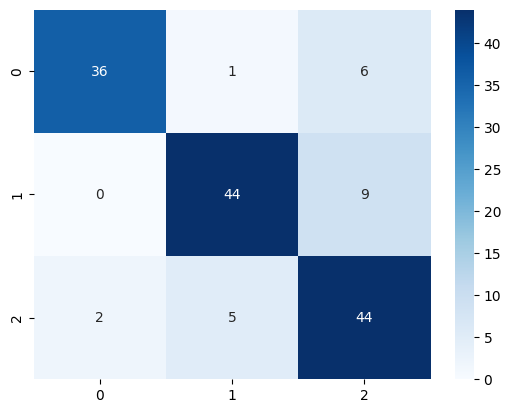


Training iteration 2/7


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3620463509.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 0.4971, 'grad_norm': 4.525167942047119, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.4856, 'grad_norm': 6.201104164123535, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.4408, 'grad_norm': 4.928798675537109, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.42089173197746277, 'eval_runtime': 11.3067, 'eval_samples_per_second': 13.001, 'eval_steps_per_second': 0.884, 'epoch': 1.0}
{'loss': 0.4259, 'grad_norm': 4.892484664916992, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.3806, 'grad_norm': 6.381522178649902, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.3055, 'grad_norm': 6.219265937805176, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.3295, 'grad_norm': 4.857372760772705, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.3742810785770416, 'eval_runtime': 12.8334, 'eval_samples_per_second': 11.454, 'eval_steps_per_second': 0.779, 'epoch': 2.0}
{'loss': 0.2234, 'grad_norm': 2.207893133163452, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.2246, 'grad_norm': 4.247824668884277, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.2159, 'grad_norm': 15.62767219543457, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.2308, 'grad_norm': 2.203061103820801, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.3729916214942932, 'eval_runtime': 14.3308, 'eval_samples_per_second': 10.258, 'eval_steps_per_second': 0.698, 'epoch': 3.0}
{'train_runtime': 551.6292, 'train_samples_per_second': 3.181, 'train_steps_per_second': 0.201, 'train_loss': 0.33962933652035826, 'epoch': 3.0}

Evaluating iteration 2:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.87      0.82      0.85        40
     Neutral       0.84      0.88      0.86        41
    Positive       0.85      0.85      0.85        66

    accuracy                           0.85       147
   macro avg       0.85      0.85      0.85       147
weighted avg       0.85      0.85      0.85       147



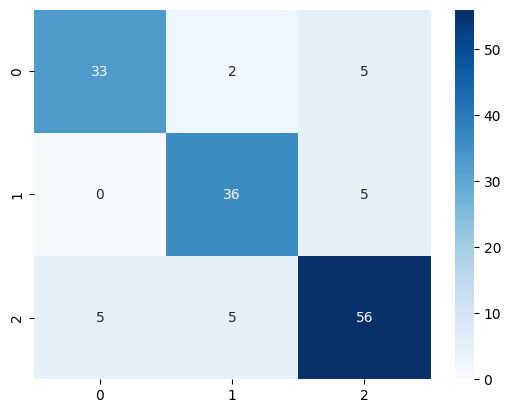


Training iteration 3/7


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3620463509.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 0.348, 'grad_norm': 16.52189826965332, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.3858, 'grad_norm': 6.36106538772583, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.5547, 'grad_norm': 4.243222236633301, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.3887569308280945, 'eval_runtime': 14.2425, 'eval_samples_per_second': 10.321, 'eval_steps_per_second': 0.702, 'epoch': 1.0}
{'loss': 0.3052, 'grad_norm': 8.245262145996094, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.3154, 'grad_norm': 3.822345733642578, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.1791, 'grad_norm': 5.905667781829834, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.249, 'grad_norm': 8.37010383605957, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.36836352944374084, 'eval_runtime': 12.6669, 'eval_samples_per_second': 11.605, 'eval_steps_per_second': 0.789, 'epoch': 2.0}
{'loss': 0.2318, 'grad_norm': 7.8680500984191895, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.211, 'grad_norm': 12.597262382507324, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.229, 'grad_norm': 4.627846717834473, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.1597, 'grad_norm': 2.073040246963501, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.3824954926967621, 'eval_runtime': 13.6897, 'eval_samples_per_second': 10.738, 'eval_steps_per_second': 0.73, 'epoch': 3.0}
{'train_runtime': 566.0795, 'train_samples_per_second': 3.1, 'train_steps_per_second': 0.196, 'train_loss': 0.2862285158118686, 'epoch': 3.0}

Evaluating iteration 3:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90        48
     Neutral       0.83      0.85      0.84        34
    Positive       0.89      0.88      0.88        65

    accuracy                           0.88       147
   macro avg       0.87      0.88      0.87       147
weighted avg       0.88      0.88      0.88       147



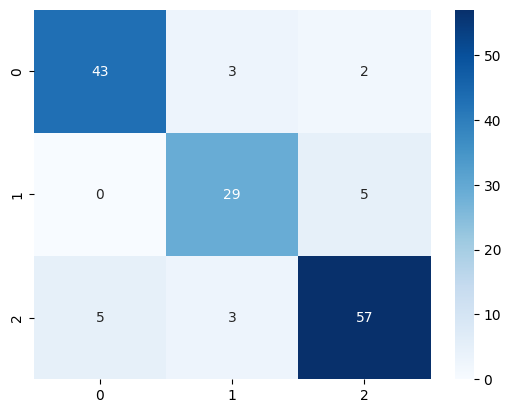


Training iteration 4/7


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3620463509.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 0.3377, 'grad_norm': 6.165856838226318, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.4711, 'grad_norm': 7.449428081512451, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.5121, 'grad_norm': 17.23610496520996, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4019794464111328, 'eval_runtime': 12.3836, 'eval_samples_per_second': 11.871, 'eval_steps_per_second': 0.808, 'epoch': 1.0}
{'loss': 0.3115, 'grad_norm': 4.869931221008301, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.3108, 'grad_norm': 33.29395294189453, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.2976, 'grad_norm': 4.812556266784668, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.3472, 'grad_norm': 4.0531768798828125, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.40684646368026733, 'eval_runtime': 12.1882, 'eval_samples_per_second': 12.061, 'eval_steps_per_second': 0.82, 'epoch': 2.0}
{'loss': 0.2262, 'grad_norm': 6.510777950286865, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.1812, 'grad_norm': 2.929567575454712, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.2392, 'grad_norm': 1.5125101804733276, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.1521, 'grad_norm': 3.128195285797119, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4137595295906067, 'eval_runtime': 14.1398, 'eval_samples_per_second': 10.396, 'eval_steps_per_second': 0.707, 'epoch': 3.0}
{'train_runtime': 543.2254, 'train_samples_per_second': 3.231, 'train_steps_per_second': 0.204, 'train_loss': 0.30585677089454893, 'epoch': 3.0}

Evaluating iteration 4:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83        48
     Neutral       0.89      0.80      0.84        30
    Positive       0.85      0.88      0.87        69

    accuracy                           0.85       147
   macro avg       0.86      0.84      0.85       147
weighted avg       0.85      0.85      0.85       147



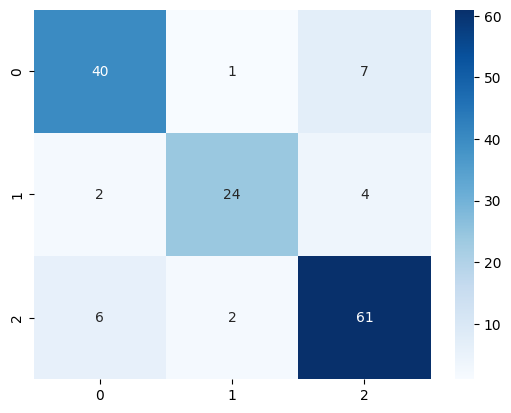


Training iteration 5/7


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3620463509.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 0.442, 'grad_norm': 7.120460033416748, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.3422, 'grad_norm': 8.277576446533203, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.3773, 'grad_norm': 7.499019622802734, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.38385239243507385, 'eval_runtime': 11.3119, 'eval_samples_per_second': 12.995, 'eval_steps_per_second': 0.884, 'epoch': 1.0}
{'loss': 0.3549, 'grad_norm': 3.2765045166015625, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.231, 'grad_norm': 10.607681274414062, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.2553, 'grad_norm': 4.757338523864746, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.1746, 'grad_norm': 2.597900390625, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.3921484649181366, 'eval_runtime': 11.7065, 'eval_samples_per_second': 12.557, 'eval_steps_per_second': 0.854, 'epoch': 2.0}
{'loss': 0.1521, 'grad_norm': 2.4684882164001465, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.1223, 'grad_norm': 1.9593234062194824, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.1709, 'grad_norm': 1.6008294820785522, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.157, 'grad_norm': 3.936708450317383, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4105428159236908, 'eval_runtime': 13.7675, 'eval_samples_per_second': 10.677, 'eval_steps_per_second': 0.726, 'epoch': 3.0}
{'train_runtime': 524.5446, 'train_samples_per_second': 3.346, 'train_steps_per_second': 0.212, 'train_loss': 0.2547914750941165, 'epoch': 3.0}

Evaluating iteration 5:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.79      0.90      0.84        50
     Neutral       0.87      0.87      0.87        45
    Positive       0.84      0.73      0.78        52

    accuracy                           0.83       147
   macro avg       0.83      0.83      0.83       147
weighted avg       0.83      0.83      0.83       147



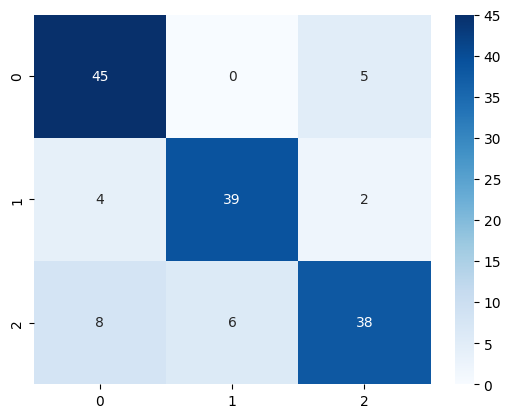


Training iteration 6/7


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3620463509.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 0.4972, 'grad_norm': 5.007477283477783, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.4192, 'grad_norm': 6.218607425689697, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.3736, 'grad_norm': 2.740583896636963, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.477904349565506, 'eval_runtime': 11.8383, 'eval_samples_per_second': 12.417, 'eval_steps_per_second': 0.845, 'epoch': 1.0}
{'loss': 0.292, 'grad_norm': 8.613516807556152, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.2502, 'grad_norm': 3.860565662384033, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.2945, 'grad_norm': 7.322945594787598, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.2849, 'grad_norm': 8.168835639953613, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.44796180725097656, 'eval_runtime': 11.6157, 'eval_samples_per_second': 12.655, 'eval_steps_per_second': 0.861, 'epoch': 2.0}
{'loss': 0.3181, 'grad_norm': 1.776207447052002, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.2584, 'grad_norm': 10.27812671661377, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.19, 'grad_norm': 0.7602821588516235, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.1191, 'grad_norm': 6.318244934082031, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.45378223061561584, 'eval_runtime': 13.8547, 'eval_samples_per_second': 10.61, 'eval_steps_per_second': 0.722, 'epoch': 3.0}
{'train_runtime': 520.8916, 'train_samples_per_second': 3.369, 'train_steps_per_second': 0.213, 'train_loss': 0.30156536897023517, 'epoch': 3.0}

Evaluating iteration 6:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.85      0.80      0.82        49
     Neutral       0.83      0.83      0.83        41
    Positive       0.82      0.86      0.84        57

    accuracy                           0.83       147
   macro avg       0.83      0.83      0.83       147
weighted avg       0.83      0.83      0.83       147



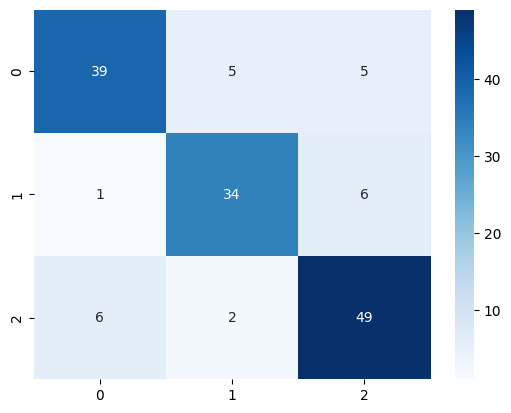


Training iteration 7/7


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3620463509.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 0.3843, 'grad_norm': 4.650752544403076, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.388, 'grad_norm': 8.53777027130127, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.2684, 'grad_norm': 14.33199405670166, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4569149315357208, 'eval_runtime': 11.3201, 'eval_samples_per_second': 12.986, 'eval_steps_per_second': 0.883, 'epoch': 1.0}
{'loss': 0.395, 'grad_norm': 9.032825469970703, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.2502, 'grad_norm': 4.498551368713379, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.1317, 'grad_norm': 6.192208766937256, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.1412, 'grad_norm': 5.153204917907715, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4710348844528198, 'eval_runtime': 11.4461, 'eval_samples_per_second': 12.843, 'eval_steps_per_second': 0.874, 'epoch': 2.0}
{'loss': 0.1255, 'grad_norm': 3.9662110805511475, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.1113, 'grad_norm': 6.376924514770508, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.1185, 'grad_norm': 8.228323936462402, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.1165, 'grad_norm': 1.56192147731781, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.47242602705955505, 'eval_runtime': 14.0012, 'eval_samples_per_second': 10.499, 'eval_steps_per_second': 0.714, 'epoch': 3.0}
{'train_runtime': 516.3757, 'train_samples_per_second': 3.399, 'train_steps_per_second': 0.215, 'train_loss': 0.21915371133736125, 'epoch': 3.0}

Evaluating iteration 7:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.81      0.94      0.87        32
     Neutral       0.86      0.82      0.84        45
    Positive       0.87      0.83      0.85        70

    accuracy                           0.85       147
   macro avg       0.85      0.86      0.85       147
weighted avg       0.85      0.85      0.85       147



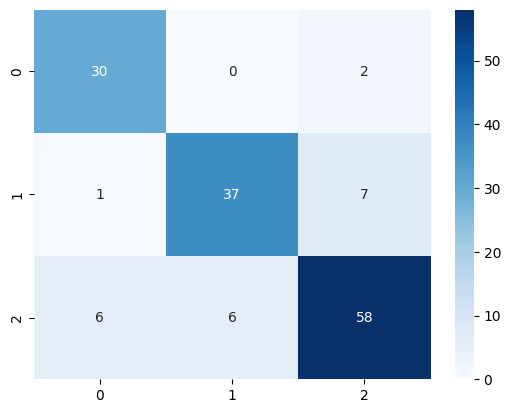


Training Engagement Model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\1545980311.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training iteration 1/3


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 1.035, 'grad_norm': 1.5708190202713013, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.9426, 'grad_norm': 2.1704864501953125, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.8474, 'grad_norm': 3.7815494537353516, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.8687297701835632, 'eval_runtime': 12.0081, 'eval_samples_per_second': 12.242, 'eval_steps_per_second': 0.833, 'epoch': 1.0}
{'loss': 0.8664, 'grad_norm': 4.034229755401611, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.8069, 'grad_norm': 3.012813091278076, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.7544, 'grad_norm': 2.6807680130004883, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.7099, 'grad_norm': 2.825132369995117, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.7699875831604004, 'eval_runtime': 11.4349, 'eval_samples_per_second': 12.855, 'eval_steps_per_second': 0.875, 'epoch': 2.0}
{'loss': 0.6441, 'grad_norm': 3.3679709434509277, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.6455, 'grad_norm': 3.2169125080108643, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.6687, 'grad_norm': 3.392500877380371, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.6411, 'grad_norm': 4.040170669555664, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.7452224493026733, 'eval_runtime': 14.1044, 'eval_samples_per_second': 10.422, 'eval_steps_per_second': 0.709, 'epoch': 3.0}
{'train_runtime': 527.0521, 'train_samples_per_second': 3.33, 'train_steps_per_second': 0.211, 'train_loss': 0.7755482376695754, 'epoch': 3.0}

Evaluating iteration 1:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         Low       0.62      0.49      0.55        41
      Medium       0.00      0.00      0.00        24
        High       0.62      0.87      0.72        82

    accuracy                           0.62       147
   macro avg       0.41      0.45      0.42       147
weighted avg       0.52      0.62      0.55       147



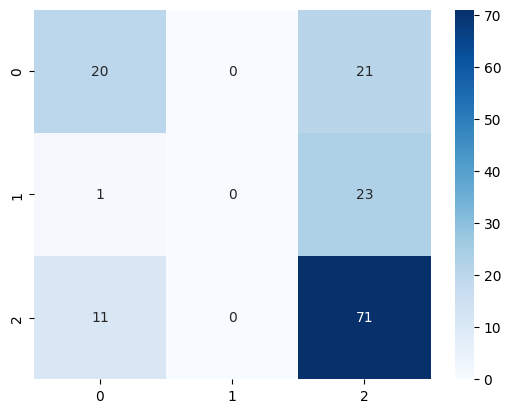


Training iteration 2/3


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\1545980311.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 0.5823, 'grad_norm': 3.967231273651123, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.5913, 'grad_norm': 4.994823932647705, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.4877, 'grad_norm': 7.600054740905762, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.6719439029693604, 'eval_runtime': 11.4638, 'eval_samples_per_second': 12.823, 'eval_steps_per_second': 0.872, 'epoch': 1.0}
{'loss': 0.4737, 'grad_norm': 10.652689933776855, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.3451, 'grad_norm': 4.78279447555542, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.349, 'grad_norm': 2.8728256225585938, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.3463, 'grad_norm': 6.65897798538208, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.589851438999176, 'eval_runtime': 11.1837, 'eval_samples_per_second': 13.144, 'eval_steps_per_second': 0.894, 'epoch': 2.0}
{'loss': 0.3001, 'grad_norm': 6.409711837768555, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.2625, 'grad_norm': 5.0715556144714355, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.2838, 'grad_norm': 6.719059467315674, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.2478, 'grad_norm': 5.094348907470703, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.5740052461624146, 'eval_runtime': 14.0244, 'eval_samples_per_second': 10.482, 'eval_steps_per_second': 0.713, 'epoch': 3.0}
{'train_runtime': 534.962, 'train_samples_per_second': 3.281, 'train_steps_per_second': 0.207, 'train_loss': 0.3860382938438708, 'epoch': 3.0}

Evaluating iteration 2:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         Low       0.77      0.73      0.75        41
      Medium       0.73      0.67      0.70        24
        High       0.78      0.82      0.80        82

    accuracy                           0.77       147
   macro avg       0.76      0.74      0.75       147
weighted avg       0.77      0.77      0.77       147



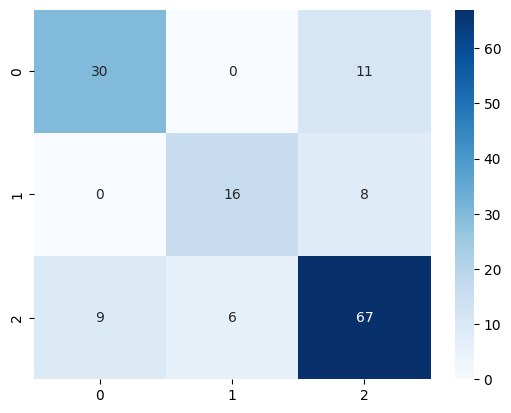


Training iteration 3/3


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\1545980311.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 0.1721, 'grad_norm': 5.92009973526001, 'learning_rate': 1.81981981981982e-05, 'epoch': 0.27}
{'loss': 0.2334, 'grad_norm': 4.719390392303467, 'learning_rate': 1.6396396396396396e-05, 'epoch': 0.54}
{'loss': 0.2181, 'grad_norm': 19.500722885131836, 'learning_rate': 1.4594594594594596e-05, 'epoch': 0.81}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.6133610606193542, 'eval_runtime': 11.2345, 'eval_samples_per_second': 13.085, 'eval_steps_per_second': 0.89, 'epoch': 1.0}
{'loss': 0.2018, 'grad_norm': 21.21042251586914, 'learning_rate': 1.2792792792792795e-05, 'epoch': 1.08}
{'loss': 0.1088, 'grad_norm': 1.8483597040176392, 'learning_rate': 1.0990990990990992e-05, 'epoch': 1.35}
{'loss': 0.136, 'grad_norm': 2.220478057861328, 'learning_rate': 9.189189189189191e-06, 'epoch': 1.62}
{'loss': 0.1501, 'grad_norm': 10.97492790222168, 'learning_rate': 7.387387387387388e-06, 'epoch': 1.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.6096106171607971, 'eval_runtime': 11.2963, 'eval_samples_per_second': 13.013, 'eval_steps_per_second': 0.885, 'epoch': 2.0}
{'loss': 0.1075, 'grad_norm': 3.8082540035247803, 'learning_rate': 5.585585585585585e-06, 'epoch': 2.16}
{'loss': 0.0612, 'grad_norm': 4.278726100921631, 'learning_rate': 3.7837837837837844e-06, 'epoch': 2.43}
{'loss': 0.0847, 'grad_norm': 5.074487209320068, 'learning_rate': 1.9819819819819822e-06, 'epoch': 2.7}
{'loss': 0.0668, 'grad_norm': 1.808067798614502, 'learning_rate': 1.801801801801802e-07, 'epoch': 2.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.6112648844718933, 'eval_runtime': 13.8491, 'eval_samples_per_second': 10.614, 'eval_steps_per_second': 0.722, 'epoch': 3.0}
{'train_runtime': 539.3757, 'train_samples_per_second': 3.254, 'train_steps_per_second': 0.206, 'train_loss': 0.13905875908361898, 'epoch': 3.0}

Evaluating iteration 3:


C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         Low       0.69      0.83      0.76        41
      Medium       0.83      0.62      0.71        24
        High       0.80      0.78      0.79        82

    accuracy                           0.77       147
   macro avg       0.78      0.74      0.75       147
weighted avg       0.78      0.77      0.77       147



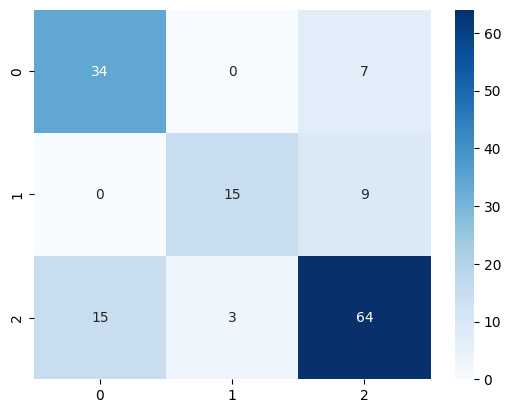

In [8]:
# Get the size of the engagement dataset
engagement_data_size = len(data2)
num_iterations = 7  # Number of times to train sentiment model

# Train sentiment model multiple times
print("Training Sentiment Model with multiple iterations...")
sentiment_model = train_sentiment_model_with_batches(
    data1,
    engagement_data_size,
    num_iterations,
    tokenizer
)

# Train engagement model normally
print("\nTraining Engagement Model...")
engagement_model = train_transformer_model(
    train_dataset2, 
    test_dataset2, 
    num_labels=3, 
    output_dir="../../../ml_models/engagement_model"
)

Step 5: Evaluate Final Models

C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/688 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      1705
     Neutral       0.87      0.84      0.86      1562
    Positive       0.86      0.88      0.87      2230

    accuracy                           0.87      5497
   macro avg       0.87      0.87      0.87      5497
weighted avg       0.87      0.87      0.87      5497



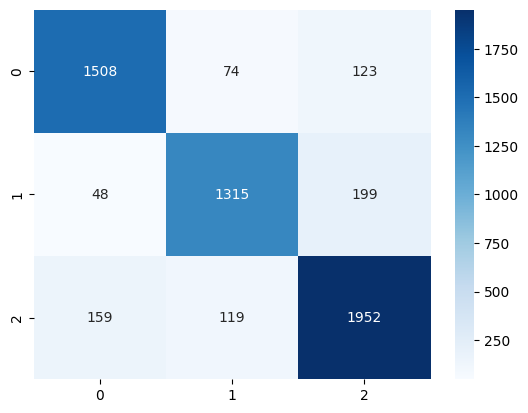

C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\4139598668.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         Low       0.69      0.83      0.76        41
      Medium       0.83      0.62      0.71        24
        High       0.80      0.78      0.79        82

    accuracy                           0.77       147
   macro avg       0.78      0.74      0.75       147
weighted avg       0.78      0.77      0.77       147



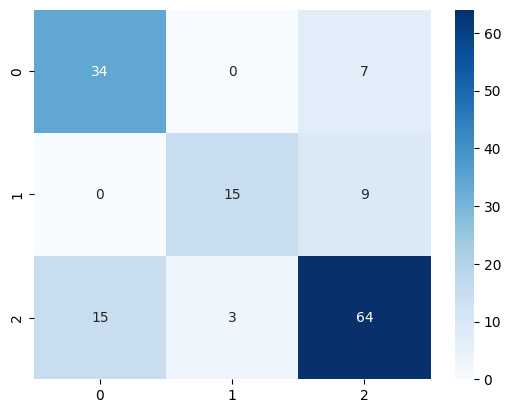

In [9]:
evaluate_model(sentiment_model, test_dataset1, ["Negative", "Neutral", "Positive"])
evaluate_model(engagement_model, test_dataset2, ["Low", "Medium", "High"])

Step 6: Meta-Model Using Transformer Outputs

In [10]:
# Create balanced datasets for feature extraction
engagement_size = len(train_dataset2)  # Use engagement dataset size as reference
sentiment_indices = np.random.choice(len(train_dataset1), size=engagement_size, replace=False)

# Create subset of sentiment dataset
train_dataset1_subset = torch.utils.data.Subset(train_dataset1, sentiment_indices)
test_dataset1_subset = torch.utils.data.Subset(test_dataset1, 
    np.random.choice(len(test_dataset1), size=len(test_dataset2), replace=False))

# Extract features using the balanced datasets
def extract_features(dataset, model):
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=TrainingArguments(
            output_dir="./tmp",
            per_device_eval_batch_size=16,
        )
    )
    predictions = trainer.predict(dataset)
    return predictions.predictions

# Extract features from both models
train_features1 = extract_features(train_dataset1_subset, sentiment_model)
train_features2 = extract_features(train_dataset2, engagement_model)

test_features1 = extract_features(test_dataset1_subset, sentiment_model)
test_features2 = extract_features(test_dataset2, engagement_model)

# Combine features for meta-model
meta_train_features = np.hstack([train_features1, train_features2])
meta_test_features = np.hstack([test_features1, test_features2])

# Get the correct labels from the engagement dataset
train_labels = [train_dataset2[i]['labels'].item() for i in range(len(train_dataset2))]
test_labels = [test_dataset2[i]['labels'].item() for i in range(len(test_dataset2))]

# Train meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_train_features, train_labels)

# Evaluate meta-model
meta_preds = meta_model.predict(meta_test_features)
print("\nMeta-model Performance:")
print(classification_report(test_labels, meta_preds))

C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3680207455.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


Meta-model Performance:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75        41
           1       0.81      0.71      0.76        24
           2       0.80      0.80      0.80        82

    accuracy                           0.78       147
   macro avg       0.78      0.76      0.77       147
weighted avg       0.78      0.78      0.78       147



Step 7: Update Prediction Function

In [11]:
# Create and fit vectorizer for sentiment analysis
vectorizer1 = TfidfVectorizer(max_features=1000)
vectorizer1.fit([text for text in texts1_train])  # Using your sentiment training texts

# Create and fit vectorizer for engagement analysis
vectorizer2 = TfidfVectorizer(max_features=1000)
vectorizer2.fit([text for text in texts2_train])  # Using your engagement training texts

# Now update the prediction function
def suggest_optimal_content(text, hashtags):
    # Prepare the text for sentiment prediction
    inputs = tokenizer(
        text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    # Get sentiment prediction
    with torch.no_grad():
        sentiment_outputs = sentiment_model(**inputs)
        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs, dim=-1).item()
    
    # Map sentiment prediction to label
    sentiment_labels = ["negative", "neutral", "positive"]
    sentiment = sentiment_labels[sentiment_pred]
    
    # Prepare text with hashtags for engagement prediction
    full_text = text + " " + " ".join(hashtags)
    inputs_engagement = tokenizer(
        full_text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    # Get engagement prediction
    with torch.no_grad():
        engagement_outputs = engagement_model(**inputs_engagement)
        engagement_probs = torch.nn.functional.softmax(engagement_outputs.logits, dim=-1)
        engagement_pred = torch.argmax(engagement_probs, dim=-1).item()
    
    # Map engagement prediction to label
    engagement_labels = ["low", "medium", "high"]  # Adjust these based on your actual labels
    engagement = engagement_labels[engagement_pred]
    
    return sentiment, engagement

# Test the function
text = "Excited about the weekend adventure!"
hashtags = ["#Travel", "#Adventure"]
sentiment, engagement = suggest_optimal_content(text, hashtags)
print(f"Predicted Sentiment: {sentiment}, Predicted Engagement: {engagement}")

Predicted Sentiment: negative, Predicted Engagement: low


Step 8: Save Models

In [12]:
os.makedirs('../../../ml_models', exist_ok=True)
joblib.dump(sentiment_model, '../../../ml_models/sentiment_model/sentiment_model.joblib')
joblib.dump(engagement_model, '../../../ml_models/engagement_model/engagement_model.joblib')
joblib.dump(meta_model, '../../../ml_models/sentiment_analysis/meta_model.joblib')
joblib.dump(vectorizer1, '../../../ml_models/sentiment_analysis/vectorizer1.joblib')
joblib.dump(vectorizer2, '../../../ml_models/sentiment_analysis/vectorizer2.joblib')

print("Models saved successfully.")

Models saved successfully.


Step 9: Cross-Validation and Learning Curves

In [13]:
# Extract features from the datasets
def extract_features_from_dataset(dataset, model):
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=TrainingArguments(
            output_dir="./tmp",
            per_device_eval_batch_size=16,
        )
    )
    predictions = trainer.predict(dataset)
    return predictions.predictions

# Extract features for sentiment analysis
X1_train = extract_features_from_dataset(train_dataset1, sentiment_model)
X1_test = extract_features_from_dataset(test_dataset1, sentiment_model)

# Extract features for engagement analysis
X2_train = extract_features_from_dataset(train_dataset2, engagement_model)
X2_test = extract_features_from_dataset(test_dataset2, engagement_model)

# Get labels
y1_train = [train_dataset1[i]['labels'].item() for i in range(len(train_dataset1))]
y1_test = [test_dataset1[i]['labels'].item() for i in range(len(test_dataset1))]
y2_train = [train_dataset2[i]['labels'].item() for i in range(len(train_dataset2))]
y2_test = [test_dataset2[i]['labels'].item() for i in range(len(test_dataset2))]

C:\Users\d-kin\AppData\Local\Temp\ipykernel_17852\3616411540.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/1374 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
class TransformerClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = np.array([0, 1, 2])  # Assuming 3 classes (0, 1, 2)
        
    def fit(self, X, y):
        # Set classes based on unique values in y
        self.classes_ = np.unique(y)
        return self
        
    def predict(self, X):
        self.model.eval()
        predictions = []
        
        with torch.no_grad():
            for batch in X:
                # Convert input_ids and attention_mask to proper tensors
                input_ids = batch['input_ids'].clone().detach()
                attention_mask = batch['attention_mask'].clone().detach()
                
                # Add batch dimension if needed
                if input_ids.dim() == 1:
                    input_ids = input_ids.unsqueeze(0)
                    attention_mask = attention_mask.unsqueeze(0)
                
                # Move to correct device
                input_ids = input_ids.to(self.model.device)
                attention_mask = attention_mask.to(self.model.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                logits = outputs.logits
                pred = torch.argmax(logits, dim=1).cpu().item()
                predictions.append(pred)
                
        return np.array(predictions)
    
    def predict_proba(self, X):
        self.model.eval()
        probabilities = []
        
        with torch.no_grad():
            for batch in X:
                # Convert input_ids and attention_mask to proper tensors
                input_ids = batch['input_ids'].clone().detach()
                attention_mask = batch['attention_mask'].clone().detach()
                
                # Add batch dimension if needed
                if input_ids.dim() == 1:
                    input_ids = input_ids.unsqueeze(0)
                    attention_mask = attention_mask.unsqueeze(0)
                
                # Move to correct device
                input_ids = input_ids.to(self.model.device)
                attention_mask = attention_mask.to(self.model.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                logits = outputs.logits
                probs = torch.softmax(logits, dim=1).cpu().numpy()
                probabilities.append(probs[0])
                
        return np.array(probabilities)

In [15]:
def evaluate_model_with_cv(model, dataset, model_name, n_folds=5):
    # Create the wrapper
    wrapped_model = TransformerClassifierWrapper(model)
    
    # Prepare data - keep tensors as is
    X = [{'input_ids': dataset[i]['input_ids'], 
          'attention_mask': dataset[i]['attention_mask']} 
         for i in range(len(dataset))]
    y = np.array([dataset[i]['labels'].item() for i in range(len(dataset))])
    
    # Perform cross-validation
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Use multiple scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'f1_weighted': 'f1_weighted',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted'
    }
    
    cv_scores = cross_validate(wrapped_model, X, y, cv=cv, scoring=scoring)
    
    print(f"\n{model_name} Cross-Validation Results:")
    for metric, scores in cv_scores.items():
        if metric.startswith('test_'):
            metric_name = metric[5:]  # Remove 'test_' prefix
            print(f"{metric_name}: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    
    return cv_scores

# Evaluate models with cross-validation
print("Evaluating Sentiment Analysis Model...")
sentiment_scores = evaluate_model_with_cv(sentiment_model, train_dataset1, "Sentiment Analysis Model")

print("\nEvaluating Engagement Model...")
engagement_scores = evaluate_model_with_cv(engagement_model, train_dataset2, "Engagement Prediction Model")

Evaluating Sentiment Analysis Model...

Sentiment Analysis Model Cross-Validation Results:
accuracy: 0.872 (+/- 0.011)
f1_weighted: 0.872 (+/- 0.011)
precision_weighted: 0.872 (+/- 0.011)
recall_weighted: 0.872 (+/- 0.011)

Evaluating Engagement Model...

Engagement Prediction Model Cross-Validation Results:
accuracy: 0.981 (+/- 0.020)
f1_weighted: 0.981 (+/- 0.022)
precision_weighted: 0.982 (+/- 0.019)
recall_weighted: 0.981 (+/- 0.020)
